In [1]:
# import special packages
import os
import math
import folium
import rasterio
import rioxarray as rxr
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.geometry as sg
import matplotlib.pyplot as plt

from matplotlib import pyplot
from math import radians, cos, sin, asin, sqrt
from folium.plugins import MeasureControl
from IPython.display import display
from shapely.geometry import Polygon
from shapely.geometry import box
from pyproj import CRS, Transformer

In [2]:
home_directory = os.path.expanduser( '~' )
os.chdir(home_directory + '/DS_Project/modules')

import pickle
import yaml
config_path = 'config.yml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
from data_retrieval.Ecostress.utils import *
from models.UHI_modeling.disaggregate import *

In [4]:
path = config['data']['data'] + '/uhi_model/grid/'

In [5]:
grid_size_meters = '200'
#with open(path + 'uhi_features_grid' + grid_size_meters + '.pkl', 'rb') as file:
#    surface_df = pickle.load(file)
with open(path + 'grid_' + grid_size_meters + '_a.pkl', 'rb') as file:
    grid = pickle.load(file)

In [6]:
grid_polygon_index = 5
subset = grid.iloc[grid_polygon_index,:].geometry

## Extract target

In [7]:
path_tif = config['data']['data'] + '/ECOSTRESS/avgAfterNoon_HW.tif'
src = rasterio.open(path_tif)
dataarray = rxr.open_rasterio(path_tif)

rioxarray.open_rasterio(path_tif).rio.bounds()

(11.310912601271106, 47.98065492314626, 11.855635150950139, 48.385108271233584)

In [8]:
Polygon.length()

TypeError: 'property' object is not callable

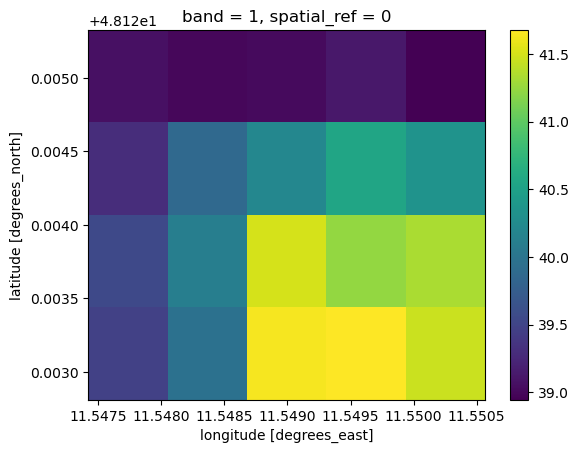

In [9]:
clip_all = dataarray.rio.clip([subset], crs=4326, all_touched=True)
clip_all.plot()


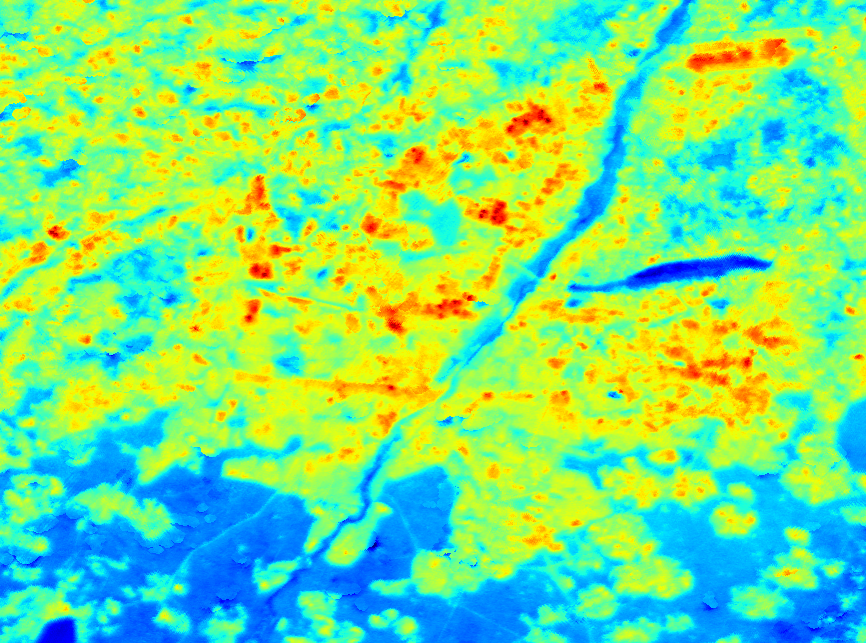

In [10]:
lst_map = tiffs_to_foliumMap(path_tif, True)
folium.GeoJson(subset.__geo_interface__, 
                style_function=lambda x: {'fillColor': 'grey', 'fillOpacity': 0.2, 'color': 'black', 'colorOpacity': 0.7}
                ).add_to(lst_map)
lst_map

In [10]:
lst_map.save(path + 'lst.html')

In [16]:
out_image, transformed = rasterio.mask.mask(src, [subset], all_touched=True, crop=True, filled=False)
clip_all = dataarray.rio.clip([subset], crs=4326, all_touched=True)
print(out_image.shape)
print(clip_all.shape)

(1, 4, 6)
(1, 4, 6)


In [17]:
clip_all

<xarray.DataArray (band: 1, y: 4, x: 6)>
array([[[35.51441884, 35.41576085, 35.91024091, 36.38908925,
         35.7345018 , 36.00229646],
        [35.94684851, 35.72505865, 35.58371146, 36.28411829,
         36.09763071, 36.1892473 ],
        [36.26097614, 36.11409811, 35.87725589, 36.07047089,
         36.62238831, 36.14960889],
        [36.15677908, 36.18114917, 36.32100906, 36.22113895,
         36.23046671, 36.31886739]]])
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 11.39 11.39 11.39 11.39 11.39 11.39
  * y            (y) float64 48.07 48.07 48.07 48.07
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [18]:
lst_pixel_map = pixels_to_foliumMap(clip_all, subset)
lst_pixel_map

NameError: name 'colors' is not defined

In [ ]:
lst_pixel_map.save(config['data']['data'] + '/uhi_model/lst_pixel_map.html')

In [ ]:
def naive_pixel_mean(array, polygon):
    c = array.rio.clip([polygon], crs=4326, all_touched=True)
    m = c.mean().values
    return m

In [ ]:
def naive_pixel_mean_wrapper(row):
    # Access the geometry of the current row
    polygon = row.geometry
    # Call the naive_pixel_mean function
    result = naive_pixel_mean(dataarray, polygon)
    
    return result

In [ ]:
# apply naive pixel mean to every grid element
lst_1000 = grid_1000['ID']
lst_1000['LST'] = grid_1000.apply(naive_pixel_mean_wrapper, axis=1)
lst_1000.head(10)

In [ ]:
temperature_data = clip_all[0].values

fig, ax = plt.subplots()
im = ax.imshow(temperature_data, cmap='spring', aspect='equal')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Temperature')

ax.set_title('Temperature Map')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

plt.show()

In [ ]:
array = clip_all
data = np.array(array)[0]

color_range = np.linspace(0, 1, 256)
colors_jet_rgba = plt.cm.jet(color_range)

colors_jet_hex = [mcolors.rgb2hex(color) for color in colors_jet_rgba]

cmap = plt.colormaps['jet']
norm = colors.Normalize(vmin=data.min(), vmax=data.max())
colored_data = cmap(norm(data))

image_bounds = box(*array.rio.bounds())
min_x, min_y, max_x, max_y = array.rio.bounds()
corner_coordinates = [[min_y, min_x], [max_y, max_x]]

In [ ]:
print(clip_all[0].shape)
clip_inner = dataarray.rio.clip([subset],all_touched=False)
print(clip_inner[0].shape)

In [ ]:
def rec_polygon_coords(polygon):
    points = list(polygon.exterior.coords)
    x_coordinates, y_coordinates = zip(*points)
    return min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates)

In [ ]:
minx, miny, maxx, maxy = clip_all.rio.bounds()
p_minx, p_miny, p_maxx, p_maxy = rec_polygon_coords(subset)
print(p_minx,p_maxx,p_miny,p_maxy)
print(minx,maxx,miny,maxy)

In [ ]:
# nach unten
print(haversine(p_minx, p_miny, p_minx, miny)*1000)
# nach rechts
print(haversine(p_maxx, p_miny, maxx, p_miny)*1000)
# nach oben
print(haversine(p_maxx, p_maxy, p_maxx, maxy)*1000)
# nach links
print(haversine(p_minx, p_maxy, minx, p_maxy)*1000)

In [ ]:
def weighted_pixel_mean(array, polygon, a=70):
    c = array.rio.clip([polygon], crs=4326, all_touched=True)
    minx, miny, maxx, maxy = c.rio.bounds()
    p_minx, p_miny, p_maxx, p_maxy = rec_polygon_coords(polygon)

    bottom = haversine(p_minx, p_miny, p_minx, miny)*1000
    right = haversine(p_maxx, p_miny, maxx, p_miny)*1000
    top = haversine(p_maxx, p_maxy, p_maxx, maxy)*1000
    left = haversine(p_minx, p_maxy, minx, p_maxy)*1000

    weights = np.ones_like(c[0].values)

    weights[0,:] = left/a
    weights[c.shape[0]-1,:] = right/a
    weights[:,0] = top/a
    weights[:,c.shape[1]-1] = bottom/a

    weights[weights > 1] = 1

    m = np.average(c[0].values,axis=None,weights=weights)

    return weights, m

In [ ]:
def weighted_pixel_mean_wrapper(row):
    # Access the geometry of the current row
    polygon = row.geometry
    # Call the weighted_pixel_mean function
    _, result = weighted_pixel_mean(dataarray, polygon)
    
    return result

In [ ]:
lst_1000['LST_weighted'] = grid_1000.apply(weighted_pixel_mean_wrapper, axis=1)